In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                                                                 | 0/60000 [00:00<?, ?it/s]

 12%|███████████████▊                                                                                                                   | 7239/60000 [00:00<00:00, 72379.20it/s]

 24%|███████████████████████████████▎                                                                                                  | 14477/60000 [00:00<00:00, 67136.64it/s]

 35%|█████████████████████████████████████████████▉                                                                                    | 21216/60000 [00:00<00:00, 63429.98it/s]

 47%|█████████████████████████████████████████████████████████████▎                                                                    | 28303/60000 [00:00<00:00, 66189.53it/s]

 59%|█████████████████████████████████████████████████████████████████████████████                                                     | 35560/60000 [00:00<00:00, 68399.66it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████                                      | 42463/60000 [00:00<00:00, 68604.98it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 49344/60000 [00:00<00:00, 65249.38it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 55909/60000 [00:00<00:00, 63884.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 65083.79it/s]

  0%|                                                                                                                                                 | 0/10000 [00:00<?, ?it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████▋                                               | 6386/10000 [00:00<00:00, 63853.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 61628.38it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 ho6dji6w


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-ho6dji6w:best, 409.57MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:8.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                   | 0/192 [00:00<?, ?it/s]

  1%|▋                                                                                                                                          | 1/192 [00:00<01:37,  1.96it/s]

  5%|███████▏                                                                                                                                  | 10/192 [00:00<00:08, 21.03it/s]

 10%|█████████████▋                                                                                                                            | 19/192 [00:00<00:04, 37.12it/s]

 15%|████████████████████▏                                                                                                                     | 28/192 [00:00<00:03, 50.10it/s]

 19%|██████████████████████████▌                                                                                                               | 37/192 [00:00<00:02, 60.47it/s]

 24%|█████████████████████████████████                                                                                                         | 46/192 [00:01<00:02, 67.48it/s]

 29%|███████████████████████████████████████▌                                                                                                  | 55/192 [00:01<00:01, 72.59it/s]

 33%|██████████████████████████████████████████████                                                                                            | 64/192 [00:01<00:01, 76.71it/s]

 38%|████████████████████████████████████████████████████▍                                                                                     | 73/192 [00:01<00:01, 80.01it/s]

 43%|██████████████████████████████████████████████████████████▉                                                                               | 82/192 [00:01<00:01, 82.41it/s]

 47%|█████████████████████████████████████████████████████████████████▍                                                                        | 91/192 [00:01<00:01, 84.07it/s]

 52%|███████████████████████████████████████████████████████████████████████▎                                                                 | 100/192 [00:01<00:01, 85.24it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▊                                                           | 109/192 [00:01<00:00, 86.07it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████▏                                                    | 118/192 [00:01<00:00, 86.65it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████▌                                              | 127/192 [00:01<00:00, 86.98it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████                                        | 136/192 [00:02<00:00, 87.23it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 145/192 [00:02<00:00, 87.48it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 154/192 [00:02<00:00, 87.57it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 163/192 [00:02<00:00, 87.70it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 172/192 [00:02<00:00, 87.75it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 181/192 [00:02<00:00, 87.76it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 190/192 [00:02<00:00, 87.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:02<00:00, 69.91it/s]

train - OK


  0%|                                                                                                                                                    | 0/48 [00:00<?, ?it/s]

  6%|████████▊                                                                                                                                   | 3/48 [00:00<00:01, 27.66it/s]

 25%|██████████████████████████████████▊                                                                                                        | 12/48 [00:00<00:00, 61.82it/s]

 44%|████████████████████████████████████████████████████████████▊                                                                              | 21/48 [00:00<00:00, 73.63it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▉                                                    | 30/48 [00:00<00:00, 79.20it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 39/48 [00:00<00:00, 82.37it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 76.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 70.39it/s]

val - OK


  0%|                                                                                                                                                    | 0/41 [00:00<?, ?it/s]

  7%|██████████▏                                                                                                                                 | 3/41 [00:00<00:01, 27.18it/s]

 29%|████████████████████████████████████████▋                                                                                                  | 12/41 [00:00<00:00, 61.42it/s]

 51%|███████████████████████████████████████████████████████████████████████▏                                                                   | 21/41 [00:00<00:00, 73.21it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 30/41 [00:00<00:00, 78.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 39/41 [00:00<00:00, 82.08it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 67.65it/s]

test InD - OK


  0%|                                                                                                                                                   | 0/268 [00:00<?, ?it/s]

  1%|█                                                                                                                                          | 2/268 [00:00<00:13, 19.53it/s]

  4%|█████▋                                                                                                                                    | 11/268 [00:00<00:04, 59.51it/s]

  7%|██████████▎                                                                                                                               | 20/268 [00:00<00:03, 72.48it/s]

 11%|██████████████▉                                                                                                                           | 29/268 [00:00<00:03, 78.53it/s]

 14%|███████████████████▌                                                                                                                      | 38/268 [00:00<00:02, 81.98it/s]

 18%|████████████████████████▏                                                                                                                 | 47/268 [00:00<00:02, 84.08it/s]

 21%|████████████████████████████▊                                                                                                             | 56/268 [00:00<00:02, 85.40it/s]

 24%|█████████████████████████████████▍                                                                                                        | 65/268 [00:00<00:02, 86.30it/s]

 28%|██████████████████████████████████████                                                                                                    | 74/268 [00:00<00:02, 86.89it/s]

 31%|██████████████████████████████████████████▋                                                                                               | 83/268 [00:01<00:02, 87.31it/s]

 34%|███████████████████████████████████████████████▎                                                                                          | 92/268 [00:01<00:02, 87.63it/s]

 38%|███████████████████████████████████████████████████▋                                                                                     | 101/268 [00:01<00:01, 87.79it/s]

 41%|████████████████████████████████████████████████████████▏                                                                                | 110/268 [00:01<00:01, 87.92it/s]

 44%|████████████████████████████████████████████████████████████▊                                                                            | 119/268 [00:01<00:01, 88.04it/s]

 48%|█████████████████████████████████████████████████████████████████▍                                                                       | 128/268 [00:01<00:01, 88.08it/s]

 51%|██████████████████████████████████████████████████████████████████████                                                                   | 137/268 [00:01<00:01, 88.12it/s]

 54%|██████████████████████████████████████████████████████████████████████████▋                                                              | 146/268 [00:01<00:01, 88.21it/s]

 58%|███████████████████████████████████████████████████████████████████████████████▏                                                         | 155/268 [00:01<00:01, 88.23it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████▊                                                     | 164/268 [00:01<00:01, 88.27it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████▍                                                | 173/268 [00:02<00:01, 88.27it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████                                            | 182/268 [00:02<00:00, 88.26it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 191/268 [00:02<00:00, 88.29it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 200/268 [00:02<00:00, 88.24it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 209/268 [00:02<00:00, 88.19it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 218/268 [00:02<00:00, 88.13it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 227/268 [00:02<00:00, 88.08it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 236/268 [00:02<00:00, 88.05it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 245/268 [00:02<00:00, 88.04it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 254/268 [00:02<00:00, 87.97it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 263/268 [00:03<00:00, 87.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 268/268 [00:03<00:00, 84.15it/s]

test OoD - OK


  0%|                                                                                                                                                   | 0/100 [00:00<?, ?it/s]

  9%|████████████▌                                                                                                                              | 9/100 [00:00<00:01, 87.78it/s]

 18%|████████████████████████▊                                                                                                                 | 18/100 [00:00<00:00, 88.02it/s]

 27%|█████████████████████████████████████▎                                                                                                    | 27/100 [00:00<00:00, 88.01it/s]

 36%|█████████████████████████████████████████████████▋                                                                                        | 36/100 [00:00<00:00, 88.02it/s]

 45%|██████████████████████████████████████████████████████████████                                                                            | 45/100 [00:00<00:00, 88.02it/s]

 54%|██████████████████████████████████████████████████████████████████████████▌                                                               | 54/100 [00:00<00:00, 88.02it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████▉                                                   | 63/100 [00:00<00:00, 88.00it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 72/100 [00:00<00:00, 87.99it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 81/100 [00:00<00:00, 87.99it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 90/100 [00:01<00:00, 87.98it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:01<00:00, 87.98it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 87.95it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(24476, 3, 32, 32) (24476, 2048) (24476, 256) (24476, 5) (24476,)
(6120, 3, 32, 32) (6120, 2048) (6120, 256) (6120, 5) (6120,)
(5139, 3, 32, 32) (5139, 2048) (5139, 256) (5139, 5) (5139,)
(34265, 3, 32, 32) (34265, 2048) (34265, 256) (34265, 5) (34265,)
(12800, 3, 32, 32) (12800, 2048) (12800, 256) (12800, 5)


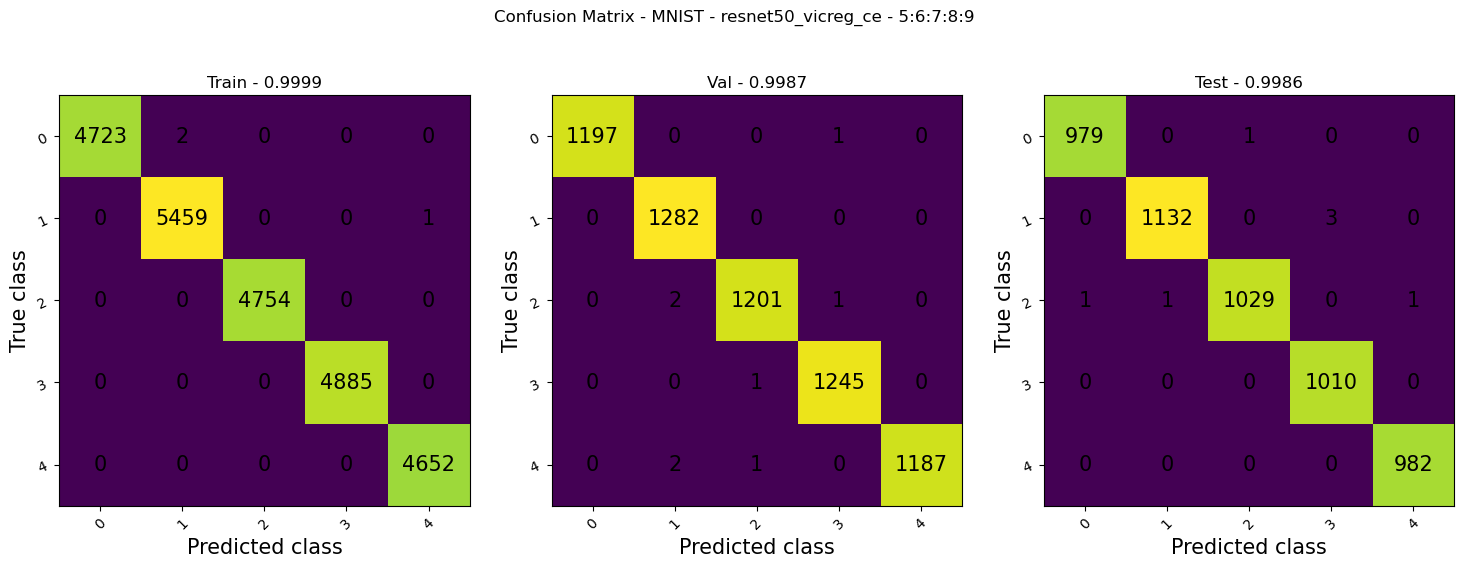

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_ftr2d = umap.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5139, 2) (34265, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5139, 2) (34265, 2)


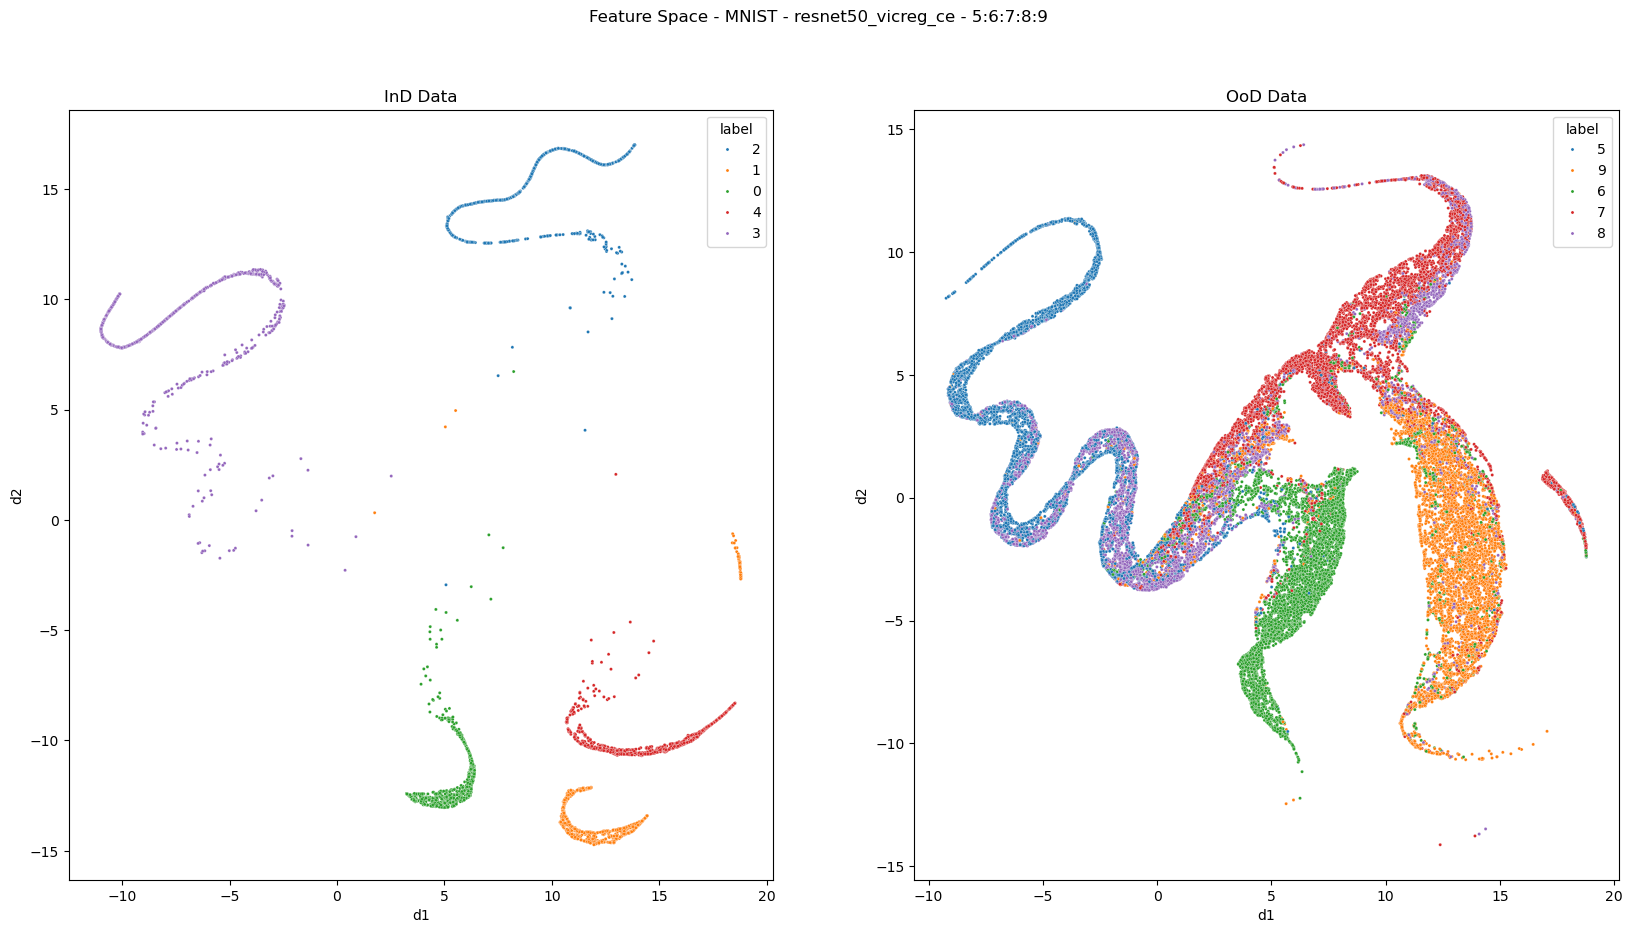

In [13]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

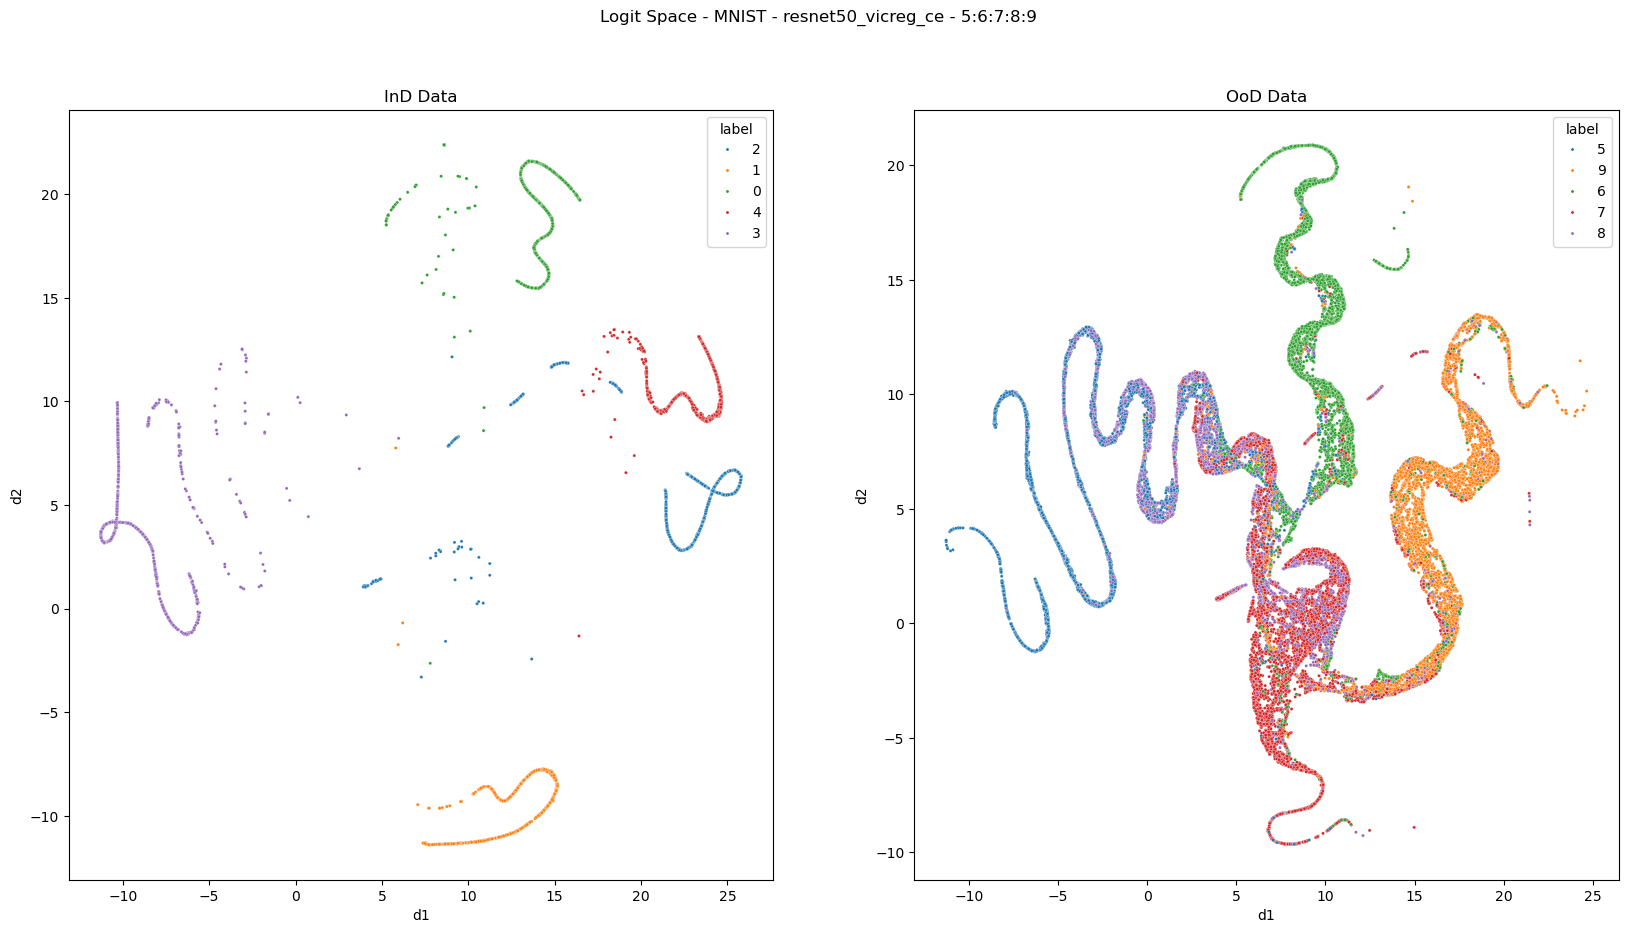

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

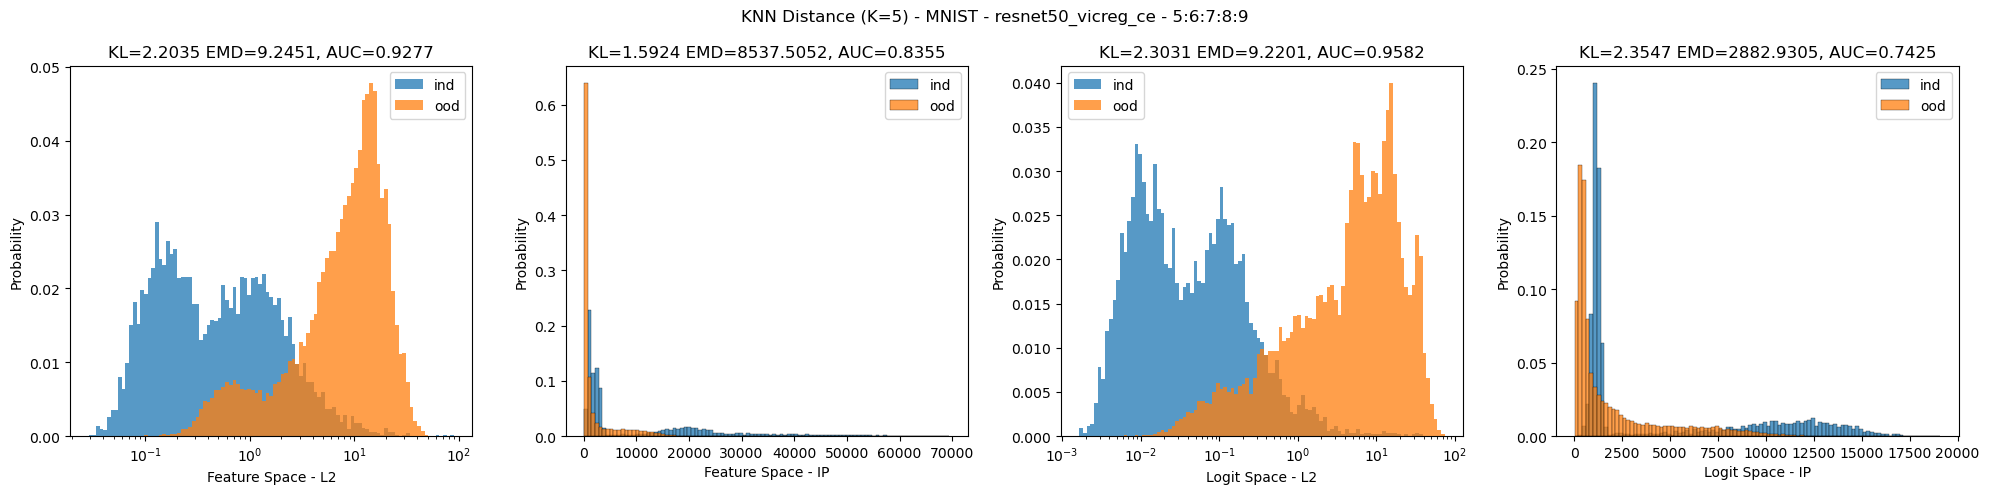

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[1], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[2], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[3], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

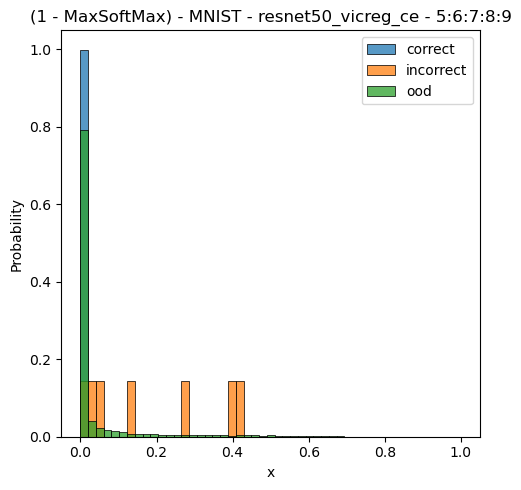

In [16]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()